<a href="https://colab.research.google.com/github/AbdellatifMamoun/Projet-Long/blob/main/VGG16_Pathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project enters the field of unsupervised learning, in particular deep clustering, which aims to properly classify unannotated data using classic clustering algorithms, such as kmeans and Birch, and use transfer learning to optimize work. In this composition, we show in stages the exploration of the data, extracting features, classifying these features and fine tuning our model which is based on the pre-trained VGG-16 network.

# Exploring Dataset

In this part, we are interested in discovering our public dataset colorectal_histology, that classifies textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.

In this context, we will see our dataset informations, and visualize some samples.

The dataset can be changeable by modifying the next cellule, where you can build or import a new data.

In [ ]:
# import and load "colorectal_histology" Dataset :
import tensorflow_datasets as tfds
ds, info = tfds.load('colorectal_histology', split='train',data_dir='/Users/asus/Desktop/Colorectal_histology', shuffle_files=True, with_info=True)


Shuffling and writing examples to /Users/asus/Desktop/Colorectal_histology/colorectal_histology/2.0.0.incompleteNO14U8/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /Users/asus/Desktop/Colorectal_histology/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [ ]:
print(info)

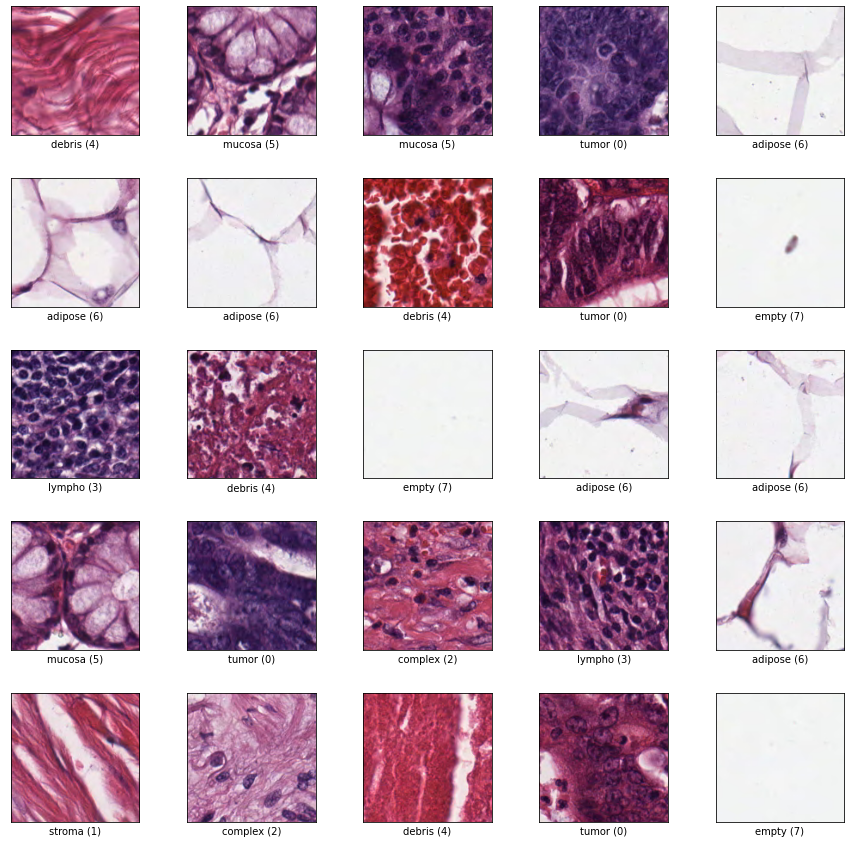

In [ ]:
# Show samples of dataset -- discovering
examples = tfds.show_examples(ds, info, rows=5, cols=5)

# Functions and librairies

Here in this section, we will present several packages, modules and functions used to implement our Deep Cluster.

In [ ]:
def TSNE_plot(X,labels,ckpt, save=True):
  '''
  TSNE plot to visualize clusters according to labels associated to features.
  This function allows to plot and save a caption of the results

  Parameters:
    X (array): array containing features
    labels (array): array containing labels
    ckpt (int): image title used to save a caption
    save (Bool): choose to save the caption or not

  Returns:
    None
    -> Visualize figure of clusters
  '''
  X=StandardScaler().fit_transform(X)
  tsne_data = TSNE(n_components=2,random_state=0, perplexity=50.0).fit_transform(X)
  tsne_data = np.vstack((tsne_data.T,labels)).T
  tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
  sn.FacetGrid(tsne_df, hue="label", size = 6).map(plt.scatter,'Dim_1', 'Dim_2' ).add_legend()
  plt.savefig("%d.png" %ckpt)
  if save:
    files.download("%d.png" %ckpt)
  plt.show()


def most_frequent(List): 
  '''
  give the most frequent element of a list.

  Parameters:
    List (array): array, object of study

  Returns:
    num (type of the elements in List): most frequent element.
  '''
  counter = 0
  num = List[0] 
      
  for i in List: 
      curr_frequency = List.count(i) 
      if(curr_frequency> counter): 
        counter = curr_frequency 
        num = i 
  
  return num 


def map(a,b, real_labels, dict, NUM_CLUSTER):
  '''
  from a given predicted and real labels, we create an equivalent array containing matches of real labels
  (transform predicted labels to real labels == bijective application)

  Parameters:
    a (int): start index
    b (int): end index
    real_labels (array): array containing labels
    dict (str): two choices -kmeans excuting kmeans alg; else execute birch alg.
    NUM_CLUSTER (int):
  Returns:
    map (list): list of predicted labels after clustering.
  '''
  map =[]
  for elm in real_labels[a:b]:
    for i in dict.keys() : 
      if dict[i] == elm : 
        map.append(i)
  return map
  
  
def dict_init(real_labels, new_labels, NUM_CLUSTER):
  '''
  Search the equivalents of the predicted labels with respect to the real labels.

  Parameters:
    real_labels (array): array containing original labels
    new_labels (int): array containing predicted labels
    NUM_CLUSTER (int): number of clusters

  Returns:
    dict (dict): dict object contains label matches.
  '''
  dict = {}
  used = []
  for i in range(NUM_CLUSTER) :
    members = (new_labels == i)
    clus = [ real_labels[i] for i in range(len(new_labels)) if members [i]]
    ks = dom(clus)
    j = 0
    while ks[j] in used:
      if j < len(ks) -1 :
        j+=1
      else :
        l = [i for i in range(NUM_CLUSTER) if not(i in used)]
        val= list(dict.values()).index(ks[j])
        dict[val] = l[0]
        used.append(l[0])
        used.remove(ks[j])
    dict[i] = ks[j]
    used.append(ks[j])
  return dict  


def dom(liste): 
  '''
  List the elements of the list according to their decreasing order of appearance.

  Parameters:
    liste (list): list, object of study

  Returns:
    res (list): list sorted by order of appearance.
  '''
  res = []
  l = liste
  while len(l)>=1 :
    m = most_frequent(l)
    res.append(m)
    l = list(filter(lambda x: x != m, l))
  return res

def freeze_until(layr,net):
  '''
  train or freeze some layers sequentially.

  Parameters:
    layer (str): Name of layer
    net (Object) : neural network
  Returns:
    None
    -> Unfreezing selected layers
  '''
  net.trainable = True 
  set_trainable = False
  for layer in net.layers:
    if layer.name == layr:
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

In [ ]:
#All the imports needed : 
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import normalized_mutual_info_score
from keras import models
from keras import layers
from keras.layers import Dense, Flatten, Dropout
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

#Parameters :
sample_count = 5000
batch_size = 20

# Image Pre-processing

At this point, we need to generate tenor. This task can be done by ImageDataGenerator, that generates batches of tensor image data with real-time pre-processing. we need to mention that we send the original test images to the model, we just scale the image pixels between 0 and 1 and do not apply any transformations.

In [ ]:
train_dir = '/Users/asus/Desktop/Colorectal_histology/downloads/extracted/ZIP.zeno.org_reco_5316_file_Kath_text_2016_imaqL7TPMR0wf27knUqk31h7Z3Aye3ukvUAeDFu7zhZbcQ.zip/Kather_texture_2016_image_tiles_5000'

#Scaling Images 

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size= 20,
        class_mode= 'categorical')

print('Rescaling done')

Found 5000 images belonging to 8 classes.
Rescaling done


# Deep Cluster : Iteration 0

In this section, we will implement the first iteration, named "iteration 0". This iteration is a set up to the main program that build our deep cluster model.

The first iteration is about creating a model is based the pre-trained neural network **VGG-16**, using random weights. 
Learning models will be used in the next section, where we will improve our neural network.

In [ ]:
# pre trained model "VGG-16"
conv_base = VGG16(weights='imagenet',
                  include_top= False,
                  input_shape=(150,150,3),
                  pooling='avg')
conv_base.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
#Extracting features using the VGG16's convolutional base

features = np.zeros(shape=(sample_count,512))
labels = np.zeros(shape=(sample_count,8))
images = np.zeros(shape=(sample_count,150,150,3))
i=0
for inputs_batch, labels_batch in train_generator:
    images[i*batch_size:(i+1)*batch_size]= inputs_batch
    labels[i*batch_size:(i+1)*batch_size]= labels_batch
    feature_batch = conv_base.predict(inputs_batch)
    features[i*batch_size:(i+1)*batch_size]= feature_batch
    i+=1
    if i*batch_size >= sample_count:
        break



In [ ]:
Clus_dataSet= features

In [ ]:
#n_init=24 is satisfactory according to the plot
k_means = KMeans(init = "k-means++", n_clusters = 8, n_init =25 )
k_means.fit( Clus_dataSet)
k_means_labels = k_means.labels_ #List of labels of each dataset
#labels
new_labels=k_means_labels

In [ ]:
#Training the Dense Classifier of the Cluster Assignements
#Our Training/Validation Data
test_images = images[4000:]

x = conv_base.output
x = Dense(128,activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(8,activation='softmax')(x)


model = Model(inputs=conv_base.input, outputs=x)

conv_base.trainable = False


model.summary()
model.save('checkpoint/0.ckpt') 




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

INFO:tensorflow:Assets written to: checkpoint/0.ckpt/assets


# Deep Cluster

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

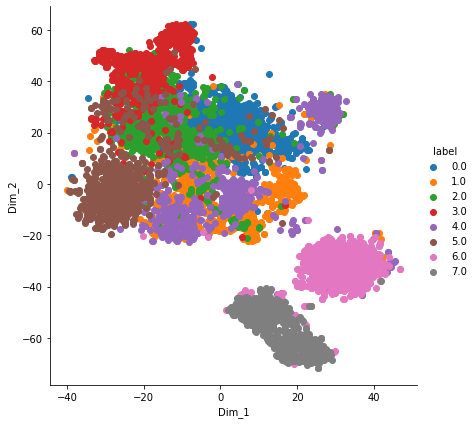

ckpt 1: # reliable images 4000


Train on 4000 samples
Epoch 1/15
4000/4000 [==============================] - 9s 2ms/sample - loss: 2.2270 - acc: 0.1688
Epoch 2/15
4000/4000 [==============================] - 9s 2ms/sample - loss: 2.1487 - acc: 0.1780
Epoch 3/15
4000/4000 [==============================] - 9s 2ms/sample - loss: 2.0660 - acc: 0.1943
Epoch 4/15
4000/4000 [==============================] - 9s 2ms/sample - loss: 1.9945 - acc: 0.2090
Epoch 5/15
4000/4000 [==============================] - 9s 2ms/sample - loss: 1.9318 - acc: 0.2405
Epoch 6/15
4000/4000 [==============================] - 9s 2ms/sample - loss: 1.8811 - acc: 0.2600
Epoch 7/15
4000/4000 [==============================] - 9s 2ms/sample - loss: 1.8358 - acc: 0.2848
Epoch 8/15
4000/4000 [==============================] - 9s 2ms/sample - loss: 1.7971 - acc: 0.3043
Epoch 9/15
4000/4000 [==============================] - 9s 2ms/sample - loss: 1.7565 - acc: 0.3183
Epoch 10/15
4000/4000 [==============================] - 9s 2ms/sample - loss: 1.7098 -

INFO:tensorflow:Assets written to: checkpoint/1.ckpt/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

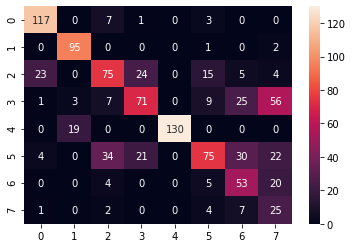

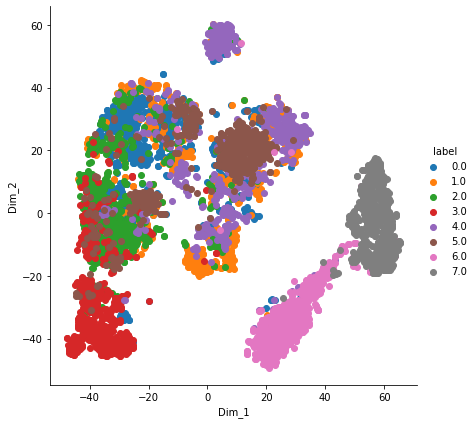

ckpt 2: # reliable images 3406
Train on 3406 samples
Epoch 1/15
3406/3406 [==============================] - 8s 2ms/sample - loss: 2.8990 - acc: 0.1979
Epoch 2/15
3406/3406 [==============================] - 8s 2ms/sample - loss: 2.4028 - acc: 0.2745
Epoch 3/15
3406/3406 [==============================] - 8s 2ms/sample - loss: 1.9676 - acc: 0.3670
Epoch 4/15
3406/3406 [==============================] - 8s 2ms/sample - loss: 1.6321 - acc: 0.4298
Epoch 5/15
3406/3406 [==============================] - 8s 2ms/sample - loss: 1.3158 - acc: 0.5176
Epoch 6/15
3406/3406 [==============================] - 8s 2ms/sample - loss: 1.1116 - acc: 0.5916
Epoch 7/15
3406/3406 [==============================] - 8s 2ms/sample - loss: 0.9578 - acc: 0.6465
Epoch 8/15
3406/3406 [==============================] - 8s 2ms/sample - loss: 0.8330 - acc: 0.6791
Epoch 9/15
3406/3406 [==============================] - 8s 2ms/sample - loss: 0.7150 - acc: 0.7355
Epoch 10/15
3406/3406 [==============================] -

INFO:tensorflow:Assets written to: checkpoint/2.ckpt/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

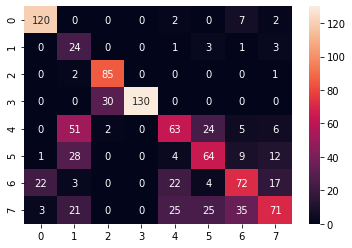

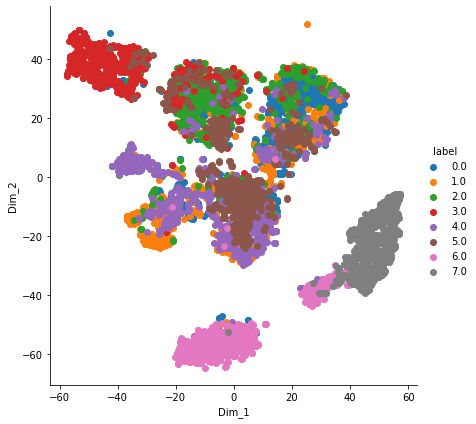

ckpt 3: # reliable images 3494
Train on 3494 samples
Epoch 1/15
3494/3494 [==============================] - 9s 3ms/sample - loss: 3.5404 - acc: 0.2138
Epoch 2/15
3494/3494 [==============================] - 8s 2ms/sample - loss: 2.7972 - acc: 0.3051
Epoch 3/15
3494/3494 [==============================] - 8s 2ms/sample - loss: 2.1350 - acc: 0.4076
Epoch 4/15
3494/3494 [==============================] - 8s 2ms/sample - loss: 1.7006 - acc: 0.4954
Epoch 5/15
3494/3494 [==============================] - 8s 2ms/sample - loss: 1.3150 - acc: 0.5939
Epoch 6/15
3494/3494 [==============================] - 8s 2ms/sample - loss: 1.0179 - acc: 0.6712
Epoch 7/15
3494/3494 [==============================] - 8s 2ms/sample - loss: 0.8666 - acc: 0.7121
Epoch 8/15
3494/3494 [==============================] - 8s 2ms/sample - loss: 0.7577 - acc: 0.7376
Epoch 9/15
3494/3494 [==============================] - 8s 2ms/sample - loss: 0.6501 - acc: 0.7779
Epoch 10/15
3494/3494 [==============================] -

INFO:tensorflow:Assets written to: checkpoint/3.ckpt/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

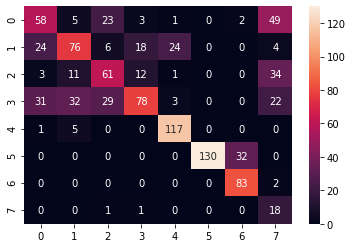

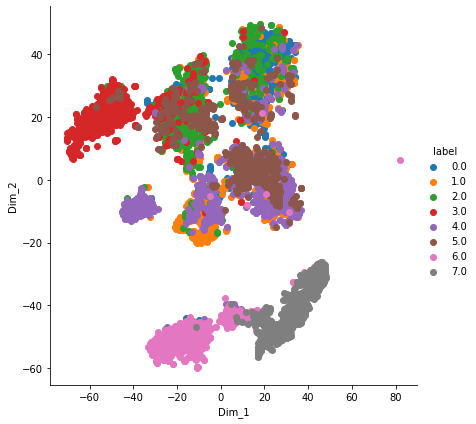

ckpt 4: # reliable images 3521
Train on 3521 samples
Epoch 1/15
3521/3521 [==============================] - 8s 2ms/sample - loss: 4.8016 - acc: 0.1960
Epoch 2/15
3521/3521 [==============================] - 8s 2ms/sample - loss: 3.7795 - acc: 0.2562
Epoch 3/15
3521/3521 [==============================] - 8s 2ms/sample - loss: 3.1242 - acc: 0.3104
Epoch 4/15
3521/3521 [==============================] - 8s 2ms/sample - loss: 2.4357 - acc: 0.4070
Epoch 5/15
3521/3521 [==============================] - 8s 2ms/sample - loss: 1.8728 - acc: 0.4996
Epoch 6/15
3521/3521 [==============================] - 8s 2ms/sample - loss: 1.5137 - acc: 0.5672
Epoch 7/15
3521/3521 [==============================] - 8s 2ms/sample - loss: 1.2129 - acc: 0.6450
Epoch 8/15
3521/3521 [==============================] - 8s 2ms/sample - loss: 1.0227 - acc: 0.6873
Epoch 9/15
3521/3521 [==============================] - 8s 2ms/sample - loss: 0.8411 - acc: 0.7259
Epoch 10/15
3521/3521 [==============================] -

INFO:tensorflow:Assets written to: checkpoint/4.ckpt/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

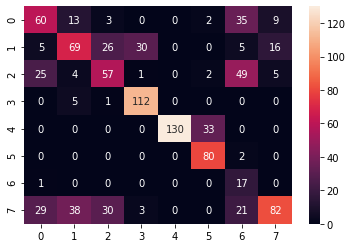

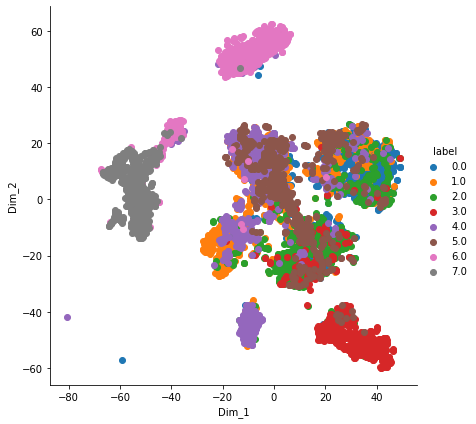

ckpt 5: # reliable images 3472
Train on 3472 samples
Epoch 1/15
3472/3472 [==============================] - 9s 3ms/sample - loss: 6.2011 - acc: 0.0999
Epoch 2/15
3472/3472 [==============================] - 8s 2ms/sample - loss: 4.8856 - acc: 0.1694
Epoch 3/15
3472/3472 [==============================] - 8s 2ms/sample - loss: 3.8672 - acc: 0.2560
Epoch 4/15
3472/3472 [==============================] - 8s 2ms/sample - loss: 3.0299 - acc: 0.3508
Epoch 5/15
3472/3472 [==============================] - 8s 2ms/sample - loss: 2.3691 - acc: 0.4499
Epoch 6/15
3472/3472 [==============================] - 8s 2ms/sample - loss: 1.8204 - acc: 0.5490
Epoch 7/15
3472/3472 [==============================] - 8s 2ms/sample - loss: 1.4464 - acc: 0.6190
Epoch 8/15
2300/3472 [==================>...........] - ETA: 2s - loss: 1.1613 - acc: 0.6804

KeyboardInterrupt: ignored

In [ ]:
# Iterate : 
#   Extract feature
#   Clustering k - means ==> labels
#   Construct training data , (images,labels)
#   Unfreeze lasts convolutionnal layers + concatenate dense layer
#   Train using k-means assignements
#   Use the new convolutinnal base to extract features
from keras.models import load_model

confusion_score=[]
true_labels = np.argmax(labels,axis=-1)
import sys
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# 
center_t = tf.compat.v1.placeholder(tf.float32, (None, None))
other_t = tf.compat.v1.placeholder(tf.float32, (None, None))
center_t_norm = tf.compat.v1.linalg.l2_normalize(center_t, dim=1)
other_t_norm = tf.compat.v1.linalg.l2_normalize(other_t, dim=1)
similarity = tf.matmul(center_t_norm, other_t_norm, transpose_a=False, transpose_b=True)



# learning
START = 1
END = 8
batch_size = 20
NUM_CLUSTER = 8
nmi_score = []

for ckpt in range(START, END+1):
  previous_labels = new_labels
  previous_model = load_model('checkpoint/%d.ckpt'%(ckpt-1))
  net = Model(inputs=previous_model.input, outputs=previous_model.get_layer('global_average_pooling2d').output)
  
  # extract features
  new_features = []
  for img in images:
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    new_features.append(np.squeeze(net.predict(img),axis=0))
  new_features = np.array(new_features)

  # clustering
  #features = PCA(features.reshape(-1,features.shape[1]*features.shape[2]*features.shape[3]))
  k_means = KMeans(init = "k-means++", n_clusters = NUM_CLUSTER, n_init =25).fit(new_features)

   # new_labels : 
  new_labels = k_means.labels_
  true_labels = np.argmax(labels,axis=-1)

  #Vizualising the clusters :
  #TSNE_plot(new_features,new_labels,ckpt) # to visualize predicted clusters 
  TSNE_plot(new_features,true_labels,ckpt) # to visualize clusters according to their real labels
  nmi_score.append(normalized_mutual_info_score(new_labels,previous_labels))
  #nmi_score_2.append(normalized_mutual_info_score(new_labels,true_labels))

  # select 
  tmp = new_features
  distances = k_means.transform(tmp) # num images * NUM_CLUSTER
  center_idx = np.argmin(distances, axis=0)
  centers = [tmp[i] for i in center_idx]
  
  #calculate similarity matrix
  with tf.compat.v1.Session() as sess:
    similarities = sess.run(similarity, {center_t: centers, other_t: tmp[:4000]}) # NUM_CLUSTER * num images

  # select reliable images
  reliable_image_idx = np.unique(np.argwhere(similarities > 0.85)[:,1])
  print ('ckpt %d: # reliable images %d'%(ckpt, len(reliable_image_idx)))
  sys.stdout.flush()
  train_images = np.array([images[i] for i in reliable_image_idx])
  train_labels = to_categorical([new_labels[i] for i in reliable_image_idx])

  #Building the training labels :
  #train_labels = to_categorical(new_labels[:4000])

  # retrain: fine tune
  init_model = load_model('checkpoint/%d.ckpt'%(ckpt-1))
  x = init_model.get_layer('global_average_pooling2d').output
  #x = Dense(128, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(NUM_CLUSTER, activation='softmax')(x)
  net = Model(inputs=init_model.input, outputs=x)
 
 
  #training the dense classifier first:
  freeze_until('global_average_pooling2d',net)
  net.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
               metrics=['acc'])
 
  history=net.fit(train_images,train_labels, batch_size=batch_size,epochs=15) 
  #Plots :


  #Jointly train the last conv block and the classifier with smaller learning rate :
  freeze_until('block5_conv1',net)
  net.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
               metrics=['acc'])
 
  history=net.fit(train_images,train_labels, batch_size=batch_size,epochs=20)

  ##Evaluating the neural network : 
  #test_labels = map(3000,5000,new_labels,true_labels, NUM_CLUSTER)
  #eval = model.evaluate(test_data,test_labels, batch_size=batch_size)
  #loss.append(eval[0])
  #acc.append(eval[1])

  init_dicct = dict_init(true_labels, new_labels, NUM_CLUSTER)
  cm=confusion_matrix(new_labels[4000:],map(4000,5000,true_labels, init_dicct, NUM_CLUSTER))
  sn.heatmap(data=cm,fmt='.0f',xticklabels=range(NUM_CLUSTER),yticklabels=range(NUM_CLUSTER),annot=True)

  #Performance score:
  confusion_score.append(accuracy_score(new_labels[4000:],map(4000,5000,true_labels,init_dicct, NUM_CLUSTER)))
 
  #Save the model : 

  net.save('checkpoint/%d.ckpt'%ckpt)

# Plot nmi , accuracy, loss
plt.figure()
epochs = range(1, len(nmi_score) + 1)

plt.plot(epochs, nmi_score, 'b', label='nmi score')
plt.title('nmi score t/t-1')

plt.legend() 



plt.figure() 
plt.plot(epochs, confusion_score, 'b', label='accuracy')
plt.title('Accuracy score')
plt.legend()

plt.show() 


# Conclusion

In this project, we succeeded in constructing a deep cluster model, which allows to classify the images well as shown by the results in the section.

The results were generally good and satisfactory. Our design can be improved by doing the similarity testing to select reliable training samples in order to avoid redundancy in our model.

Generally, the deep clustering task was successfully as the model was able to adapt and recognize clusters of different type of images. Therfore, deep learning and domain adaptation are considerably the key to improve the field of pathology AI, especially, for pathology data that has not yet been processed.